# import needed libraries

In [ ]:
import os
import PIL as Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# read data

## train

In [ ]:
train_dir='/content/drive/MyDrive/archive (7).zip (Unzipped Files)/Training'
filepath=[]
labels=[]
folds=os.listdir(train_dir)
for fold in folds:
    filpath=os.path.join(train_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath')
l_series=pd.Series(labels,name='labels')
train_df=pd.concat([f_series,l_series],axis=1)

In [ ]:
train_df

## test

In [ ]:
dummy_dir='/content/drive/MyDrive/archive (7).zip (Unzipped Files)/Testing'
filepath=[]
labels=[]
folds=os.listdir(dummy_dir)
for fold in folds:
    filpath=os.path.join(dummy_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath')
l_series=pd.Series(labels,name='labels')
dummy_df=pd.concat([f_series,l_series],axis=1)

In [ ]:
dummy_df

# preprocessing

In [ ]:
count_train=train_df["labels"].value_counts()
count_train

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: labels, dtype: int64

In [ ]:
count_dummy=dummy_df["labels"].value_counts()
count_dummy

notumor       405
meningioma    306
glioma        300
pituitary     300
Name: labels, dtype: int64

# split dummy_df to test and valid

In [ ]:
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=dummy_df['labels'])

# create image data generator

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# sample from data

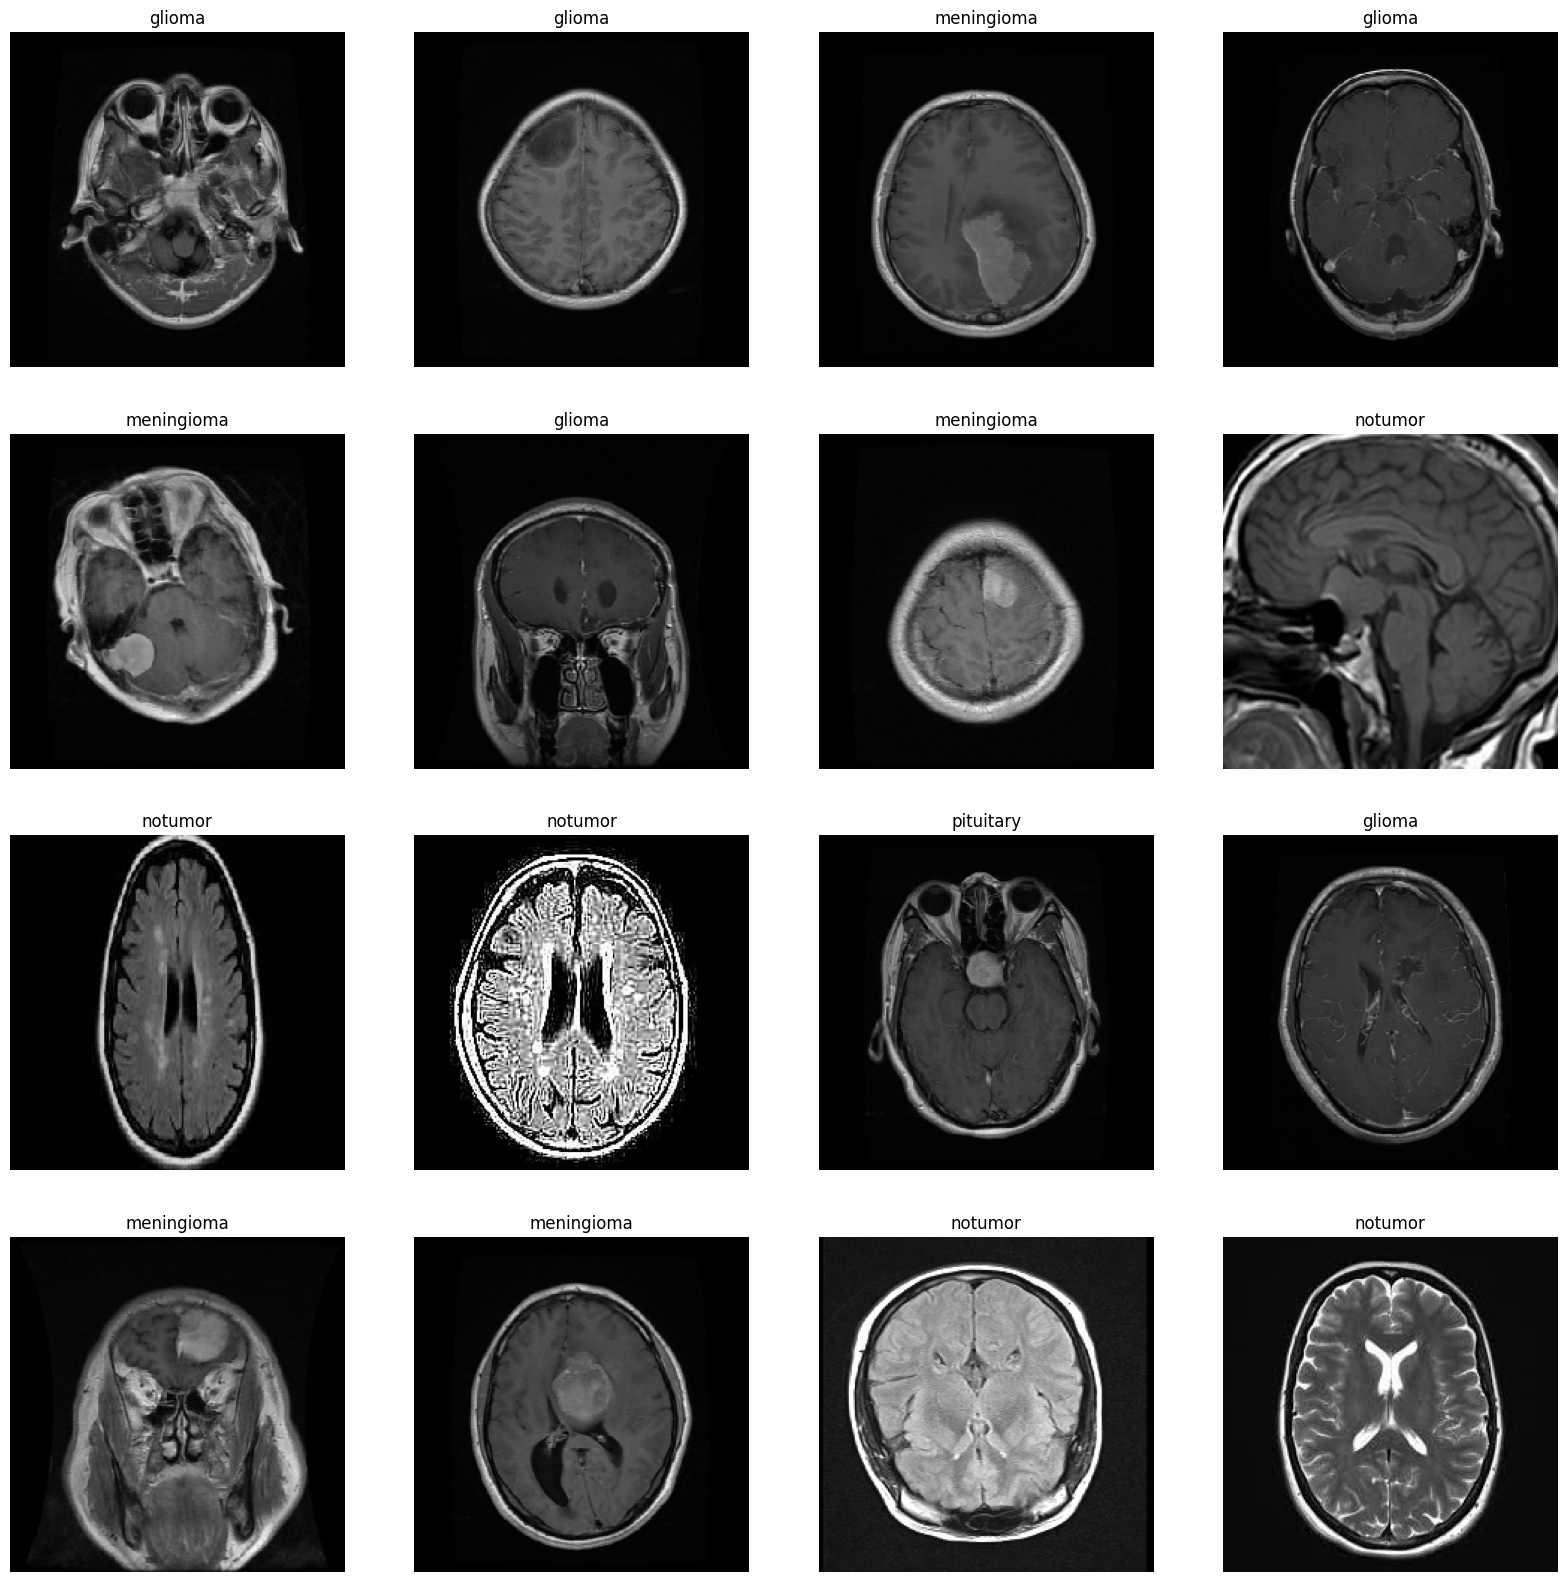

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

# Build model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


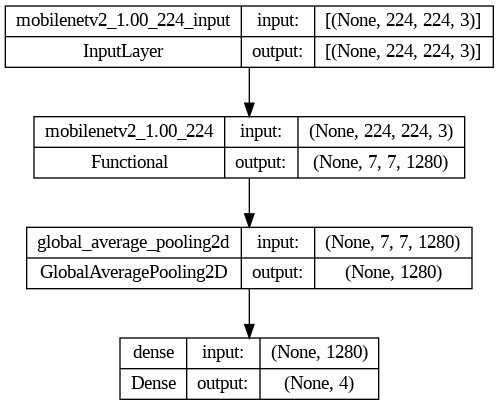

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
history=model.fit(train_gen,epochs=10,validation_data=valid_gen,shuffle=False, validation_steps= None)

Epoch 1/10
357/357 [==============================] - 3357s 9s/step - loss: 0.5756 - accuracy: 0.7784 - val_loss: 0.5231 - val_accuracy: 0.7985
Epoch 2/10
357/357 [==============================] - 36s 101ms/step - loss: 0.3467 - accuracy: 0.8775 - val_loss: 0.4463 - val_accuracy: 0.8366
Epoch 3/10
357/357 [==============================] - 36s 102ms/step - loss: 0.2901 - accuracy: 0.8943 - val_loss: 0.4018 - val_accuracy: 0.8382
Epoch 4/10
357/357 [==============================] - 35s 98ms/step - loss: 0.2542 - accuracy: 0.9072 - val_loss: 0.3329 - val_accuracy: 0.8687
Epoch 5/10
357/357 [==============================] - 35s 98ms/step - loss: 0.2305 - accuracy: 0.9168 - val_loss: 0.3571 - val_accuracy: 0.8580
Epoch 6/10
357/357 [==============================] - 36s 100ms/step - loss: 0.2156 - accuracy: 0.9212 - val_loss: 0.3302 - val_accuracy: 0.8748
Epoch 7/10
357/357 [==============================] - 36s 100ms/step - loss: 0.2021 - accuracy: 0.9256 - val_loss: 0.2872 - val_accur

# Evalution

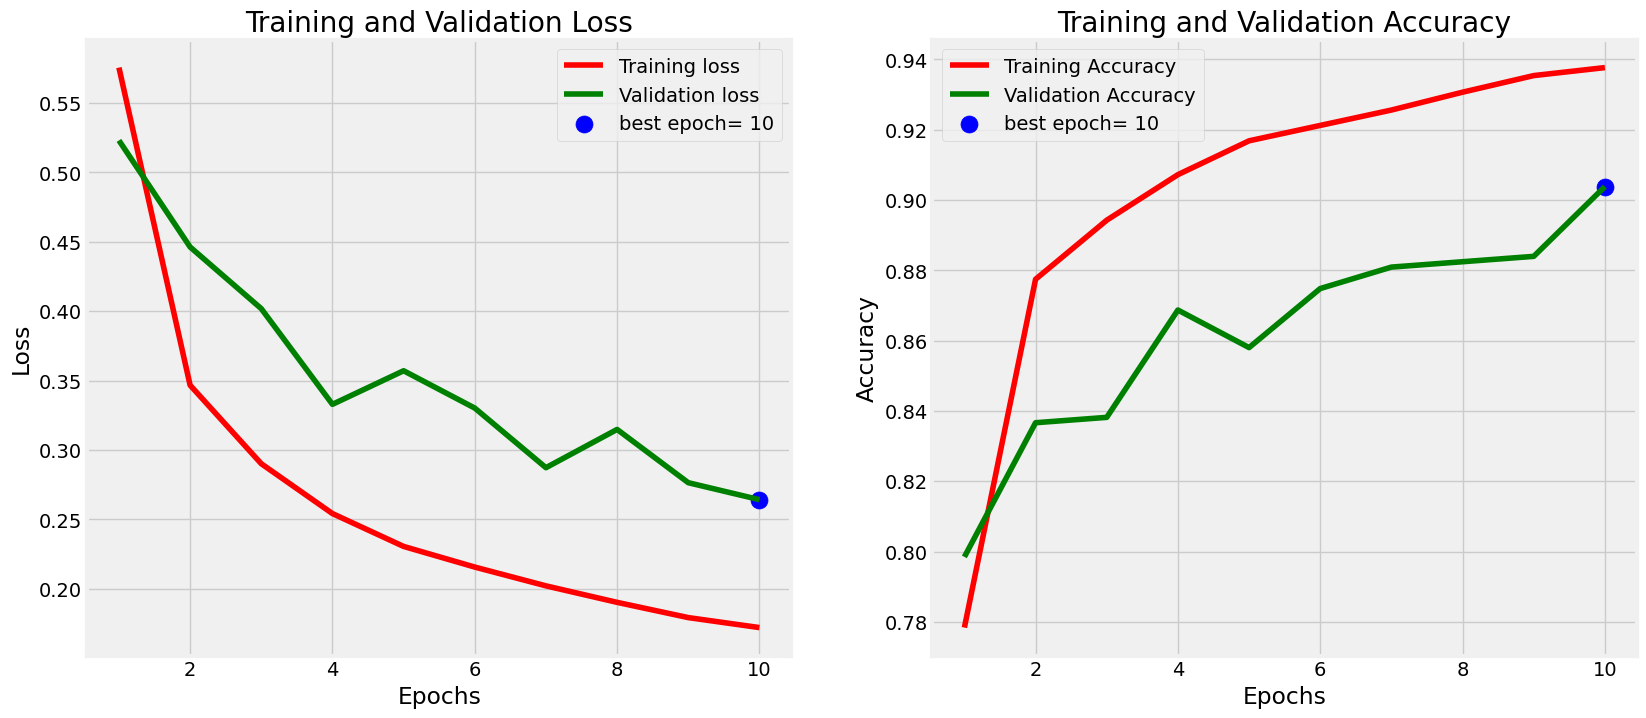

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 166s 11s/step - loss: 0.2464 - accuracy: 0.8867
Train Loss:  0.16235315799713135
Train Accuracy:  0.94921875
--------------------
Valid Loss:  0.26562315225601196
Valid Accuracy:  0.90234375
--------------------
Test Loss:  0.24637988209724426
Test Accuracy:  0.88671875


# prediction

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-22-01135dd8c8ed>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


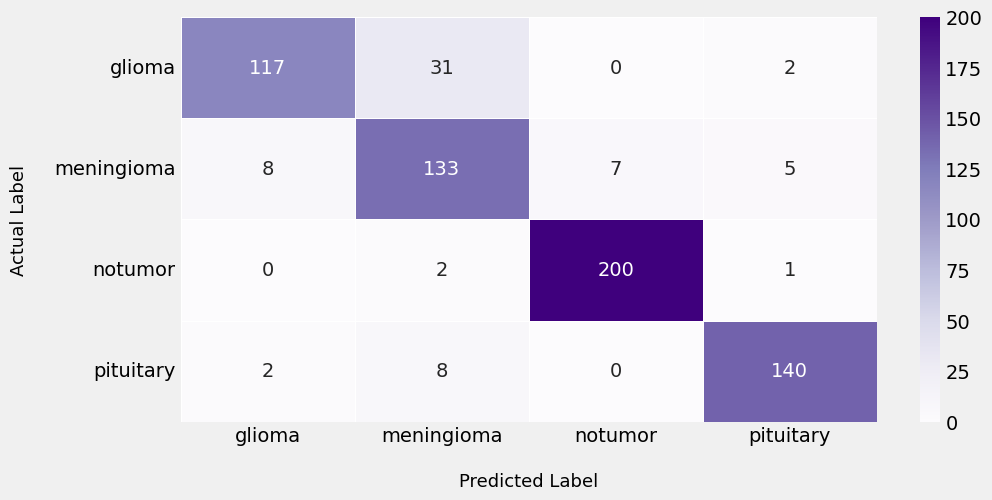

In [ ]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Purples", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.92      0.78      0.84       150
  meningioma       0.76      0.87      0.81       153
     notumor       0.97      0.99      0.98       203
   pituitary       0.95      0.93      0.94       150

    accuracy                           0.90       656
   macro avg       0.90      0.89      0.89       656
weighted avg       0.90      0.90      0.90       656



In [ ]:
model.save('brain-tumor.h')